# Set Up

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sentencepiece
!pip install transformers

     |████████████████████████████████| 1.2 MB 7.9 MB/s 
     |████████████████████████████████| 4.2 MB 8.3 MB/s 
     |████████████████████████████████| 596 kB 63.6 MB/s 
     |████████████████████████████████| 6.6 MB 54.6 MB/s 
     |████████████████████████████████| 84 kB 1.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!cp /content/drive/MyDrive/mumin-classifier/tg_data.py /content
!cp /content/drive/MyDrive/mumin-classifier/data_utils.py /content
!cp /content/drive/MyDrive/mumin-classifier/finetuning_utils.py /content

# Training

In [ ]:
def compute_metrics(eval_pred):
    """Computes accuracy, f1, precision, and recall from a 
    transformers.trainer_utils.EvalPrediction object.
    """
    from sklearn import metrics
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.argmax(-1)

    accuracy = metrics.accuracy_score(y_true=labels, y_pred=preds)
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true=labels, y_pred=preds, average="macro")

    result = {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

    return result

def model_init():
    """Returns an initialized model for use in a Hugging Face Trainer."""
    from transformers import XLMRobertaConfig, XLMRobertaForSequenceClassification

    configuration = XLMRobertaConfig()
    model = XLMRobertaForSequenceClassification(configuration).from_pretrained("xlm-roberta-base")

    return model


In [ ]:
import argparse
import tg_data
import data_utils
import pandas as pd
import torch
import transformers
from transformers import XLMRobertaTokenizer, Trainer, TrainingArguments
from transformers import BertTokenizer, XLMRobertaForSequenceClassification
import sklearn
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score


train_df = pd.read_csv("/content/drive/MyDrive/mumin-classifier/data/train_m.csv")
val_df = pd.read_csv("/content/drive/MyDrive/mumin-classifier/data/val_m.csv")
test_df = pd.read_csv("/content/drive/MyDrive/mumin-classifier/data/test_m.csv")

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
train_data = tg_data.TGDataset(train_df, tokenizer)
val_data = tg_data.TGDataset(val_df, tokenizer)
test_data = tg_data.TGDataset(test_df, tokenizer)

model_path = "out_xlmroberta"
trainingargs = TrainingArguments(
    output_dir=model_path,
    do_train=True,
    do_eval=True,
    disable_tqdm=False,
    learning_rate=1e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=500,
    logging_first_step=True,
    #save_steps=1000,
    evaluation_strategy = "epoch"
    )

trainer = Trainer(
    args = trainingargs,
    tokenizer = tokenizer,
    train_dataset = train_data,
    eval_dataset = val_data,
    model_init = model_init,
    compute_metrics = compute_metrics
    )

print("STARTED TRAINING")
trainer.train()
print("TRAINING DONE")

trainer.save_model()
print("MODEL SAVED")    

#Metrics
model = XLMRobertaForSequenceClassification.from_pretrained(model_path)

predictions = trainer.predict(val_data)
preds = np.argmax(predictions.predictions, axis=-1)


accuracy = metrics.accuracy_score(y_true=predictions.label_ids, y_pred=preds)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true=predictions.label_ids, y_pred=preds, average="macro")

print({'accuracy': accuracy,
       'f1': f1,
       'precision': precision,
       'recall': recall})

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

loading configuration file https://huggingface.co/xlm-roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.dfaaaedc7c1c475302398f09706cbb21e23951b73c6e2b3162c1c8a99bb3b62a
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

https://huggingface.co/xlm-roberta-base/resolve/main/py

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

storing https://huggingface.co/xlm-roberta-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2
creating metadata file for /root/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2
loading weights file https://huggingface.co/xlm-roberta-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.d

STARTED TRAINING


loading configuration file https://huggingface.co/xlm-roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.dfaaaedc7c1c475302398f09706cbb21e23951b73c6e2b3162c1c8a99bb3b62a
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file https://huggingface.co/xlm-roberta

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.713600,0.065513,0.987692,0.496904,0.493846,0.500000
2,0.345900,0.245222,0.829231,0.470556,0.503821,0.543224
3,0.281900,0.273809,0.886154,0.495363,0.509113,0.572040


***** Running Evaluation *****
  Num examples = 650
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to out_xlmroberta/checkpoint-500
Configuration saved in out_xlmroberta/checkpoint-500/config.json
Model weights saved in out_xlmroberta/checkpoint-500/pytorch_model.bin
tokenizer config file saved in out_xlmroberta/checkpoint-500/tokenizer_config.json
Special tokens file saved in out_xlmroberta/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 650
  Batch size = 8
Saving model checkpoint to out_xlmroberta/checkpoint-1000
Configuration saved in out_xlmroberta/checkpoint-1000/config.json
Model weights saved in out_xlmroberta/checkpoint-1000/pytorch_model.

TRAINING DONE


Model weights saved in out_xlmroberta/pytorch_model.bin
tokenizer config file saved in out_xlmroberta/tokenizer_config.json
Special tokens file saved in out_xlmroberta/special_tokens_map.json
loading configuration file out_xlmroberta/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.19.0",
  "type_vocab_size": 1,


MODEL SAVED


All model checkpoint weights were used when initializing XLMRobertaForSequenceClassification.

All the weights of XLMRobertaForSequenceClassification were initialized from the model checkpoint at out_xlmroberta.
If your task is similar to the task the model of the checkpoint was trained on, you can already use XLMRobertaForSequenceClassification for predictions without further training.
***** Running Prediction *****
  Num examples = 650
  Batch size = 8


{'accuracy': 0.8861538461538462, 'f1': 0.49536279323513366, 'precision': 0.5091133004926108, 'recall': 0.5720404984423676}


In [ ]:

predictions = trainer.predict(test_data)
preds = np.argmax(predictions.predictions, axis=-1)

test_scores = f1_score(test_data.label_list, preds, average=None) # the labels were for test not val initially - I changed this
print(f'macro-average F1: {100 * test_scores.mean():.4f}%')


report = sklearn.metrics.classification_report(y_pred=preds, y_true=predictions.label_ids)

print(report)

***** Running Prediction *****
  Num examples = 543
  Batch size = 8


macro-average F1: 56.4950%
              precision    recall  f1-score   support

           0       0.13      0.32      0.19        22
           1       0.97      0.91      0.94       521

    accuracy                           0.89       543
   macro avg       0.55      0.62      0.56       543
weighted avg       0.94      0.89      0.91       543



In [ ]:
print(f'Misinformation F1: {100 * test_scores[1]:.2f}%')
print(f'Factual F1: {100 * test_scores[0]:.2f}%')

Misinformation F1: 94.07%
Factual F1: 18.92%


# Langauges

In [ ]:
from sklearn.dummy import DummyClassifier
langs = pd.concat([val_df, test_df])
langs = langs.query("lang=='en' | lang=='pt' | lang=='es'| lang=='fr'| lang=='ar'")
languages = ['en','pt','es','fr','ar']
f1 = []
randomf1 = []
for lang in languages:
  print("\nLANG ", lang)
  lang_data = langs.query(f"lang=='{lang}'")
  test_data = tg_data.TGDataset(lang_data, tokenizer)
  predictions = trainer.predict(test_data)
  preds = np.argmax(predictions.predictions, axis=-1)

  test_scores = f1_score(test_data.label_list, preds, average=None)

  print(f'\nMisinformation F1: {100 * test_scores[1]:.2f}%')
  print(f'Factual F1: {100 * test_scores[0]:.2f}%')
  print(f'macro-average F1: {100 * test_scores.mean():.4f}%\n')
  f1.append(100 * test_scores.mean())

  model = DummyClassifier(strategy="most_frequent")

  lang_train_data = train_df.query(f"lang=='{lang}'")

  model.fit(lang_train_data.text, lang_train_data.label)

  test_preds = model.predict(lang_data.text)

  test_scores = f1_score(lang_data.label, test_preds , average=None)

  print(f'\nMisinformation F1: {100 * test_scores[1]:.2f}%')
  print(f'Factual F1: {100 * test_scores[0]:.2f}%')
  print(f'macro-average F1: {100 * test_scores.mean():.4f}%\n')
  randomf1.append(100 * test_scores.mean())


***** Running Prediction *****
  Num examples = 680
  Batch size = 8



LANG  en


***** Running Prediction *****
  Num examples = 182
  Batch size = 8



Misinformation F1: 92.75%
Factual F1: 13.33%
macro-average F1: 53.0412%


Misinformation F1: 98.28%
Factual F1: 0.00%
macro-average F1: 49.1399%


LANG  pt


***** Running Prediction *****
  Num examples = 111
  Batch size = 8



Misinformation F1: 97.75%
Factual F1: 0.00%
macro-average F1: 48.8764%


Misinformation F1: 99.72%
Factual F1: 0.00%
macro-average F1: 49.8623%


LANG  es


***** Running Prediction *****
  Num examples = 66
  Batch size = 8



Misinformation F1: 97.22%
Factual F1: 0.00%
macro-average F1: 48.6111%


Misinformation F1: 99.09%
Factual F1: 0.00%
macro-average F1: 49.5455%


LANG  fr


***** Running Prediction *****
  Num examples = 38
  Batch size = 8



Misinformation F1: 90.00%
Factual F1: 0.00%
macro-average F1: 45.0000%


Misinformation F1: 99.24%
Factual F1: 0.00%
macro-average F1: 49.6183%


LANG  ar

Misinformation F1: 86.57%
Factual F1: 0.00%
macro-average F1: 43.2836%


Misinformation F1: 98.67%
Factual F1: 0.00%
macro-average F1: 49.3333%



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:514: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:52

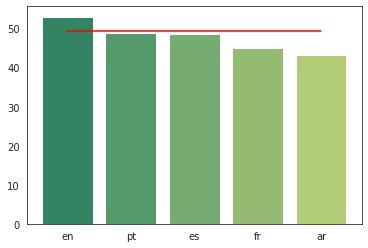

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("summer")
sns.set_style("white")
sns.barplot(languages, f1)
sns.lineplot(languages, sum(randomf1)/len(randomf1), c="r")

In [ ]:
randomf1

[49.13986537023186,
 49.862258953168045,
 49.54545454545454,
 49.61832061068702,
 49.33333333333333]